In this notebook, we go through our post-processing steps. We will decide on a model to use, then:
1. - Apply the model to our validation and test sets, or
   -  Load the same pre-generated data from a file
2. Find the best threshold using the validation set
3. Test the model at its best using various metrics

In [1]:
import torch
import numpy as np
import os
import sklearn.metrics

from model.unet_model import UNet
from visualisation import plot_precision_recall_f1, show_full_comparisonTestGenerator

from load_data import *
from post_processing import *

new_section = "=" * 50
# All the metrics available for testing.
METRICS = get_metrics() # A dict of sklearn metrics

In [2]:
dir_models = "../saved_models"
dir_data = "../data"
model_name = "21Adam_e_3_50noPV_BCEwithweights_epochs_80_schedulere_4_at50"

# Load data from a file, don't generate it again
from_file = True

# Save data to a file (irrelevant if `from_file` is set)
to_file = False

# File where validation and test data are stored,
# or will be if they aren't already and `to_file` is set
data_file_name = "data.npz"

# Number of thresholds to try when `validation` is set
n_thresholds = 101

# Compute the metrics on the concatenation of all images in the set,
# instead of doing it for each image individually
concat = True

# Whether to plot a precision-recall curve and the F1-score during the threshold search
plot = True

# Which metrics to apply during test phase
test = ["precision", "recall", "f1", "jaccard"]

for metric in test:
    if metric not in METRICS.keys():
        raise ValueError(f"{metric} is not a valid metric. Valid metrics are:\n{list(METRICS.keys())}")

1. __Getting data__

If `from_file` is set we load data from a file specified in `data_file`.
Otherwise we use the parameters to produce that data, and save it to `data_file` if `to_file` is set.

In [3]:
model_dir = os.path.join(dir_models, model_name)
params_file = os.path.join(model_dir, model_name)
data_file = os.path.join(model_dir, data_file_name)
print(new_section)
if from_file:
    print("Loading data")
    arrays = np.load(data_file)
    val_predictions, val_labels, test_predictions, test_labels = arrays.values()
else:
    print("Loading model")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet(n_channels=3, n_classes=1, bilinear=False)
    model = model.to(device)
    model.load_state_dict(torch.load(params_file, map_location=device))
    model.eval()

    print("Generating data")
    dir_data_validation = os.path.join(dir_data, "validation")
    dir_data_test = os.path.join(dir_data, "test")

    _, validation_dl, test_dl = load_data(
        dir_data_validation=dir_data_validation,
        dir_data_test=dir_data_test,
        prop_noPV_training=0,  # Has no impact
        min_rescale_images=0,  # Has no impact
        batch_size=100,  # All of them
    )
    with torch.no_grad():
        # Get images and labels from both DataLoaders
        val_images, val_labels = next(iter(validation_dl))
        test_images, test_labels = next(iter(test_dl))
        val_images = val_images.to(device, dtype=torch.float32)
        test_images = test_images.to(device, dtype=torch.float32)
        # Make predictions (predictions are not probabilities at this stage)
        print("Running model on data")
        val_predictions = model(val_images)
        test_predictions = model(test_images)
        # Convert to numpy arrays for computing
        val_predictions = np.squeeze(val_predictions.cpu().numpy())
        val_labels = np.squeeze(val_labels.cpu().numpy())
        test_predictions = np.squeeze(test_predictions.cpu().numpy())
        test_labels = np.squeeze(test_labels.cpu().numpy())
        # Save to file as numpy arrays to avoid having to run again (the images will always be the same)
        if to_file:
            print("Saving results to file")
            np.savez_compressed(
                data_file,
                val_predictions=val_predictions,
                val_labels=val_labels,
                test_predictions=test_predictions,
                test_labels=test_labels,
            )
print("Done!")

Loading data
Done!


2. __Finding the best threshold: we use the validation set to compute precision, recall and the F1-score.__

We define the "best" threshold to be the one that
maximises the F1-score if `concat` is set, and the median F1-score otherwise.

Validation starting


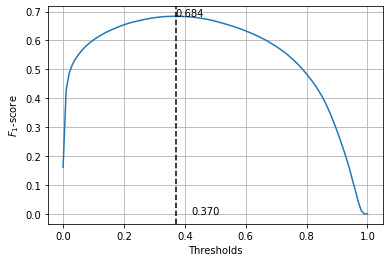

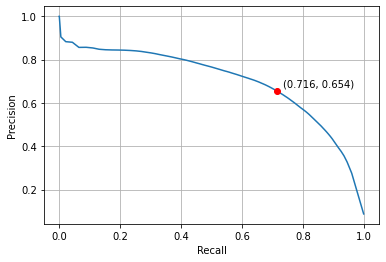

Found best threshold to be 0.3700


In [4]:
print(new_section)
print("Validation starting")
_, _, _, best_threshold = find_best_threshold(
    val_predictions, val_labels, n_thresholds, concat=concat, plot=plot
)
print(f"Found best threshold to be {best_threshold:.4f}")

3. Testing the model at its best: we compute metrics on the test set using the best threshold we found at the previous step.

In [5]:
print(new_section)
print("Testing starting with metrics:")
print(", ".join(test))
results = test_model(test_predictions, test_labels, best_threshold, concat, *test)
summary_type = "median"

if concat:
    results_summary = np.transpose(results)
    print("Results:")
else:
    results_summary = np.transpose(summary_stats(results, type=summary_type))
    print(f"Summary statistics are based on the {summary_type}")
    print("Results (lower, mid-point, upper):")
print(f"\tBest threshold:\t{best_threshold:.4f}")
for i, measure in enumerate(test):
    print("\t{}:\t{}".format(measure, results_summary[i, :]))

Testing starting with metrics:
precision, recall, f1, jaccard
Results:
	Best threshold:	0.3700
	precision:	[0.74913919]
	recall:	[0.78617524]
	f1:	[0.76721051]
	jaccard:	[0.62233699]


In [6]:
# If the model wasn't loaded before, load it now
try:
    model
except NameError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet(n_channels=3, n_classes=1, bilinear=False)
    model = model.to(device)
    model.load_state_dict(torch.load(params_file, map_location=device))
    model.eval()

Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Displaying


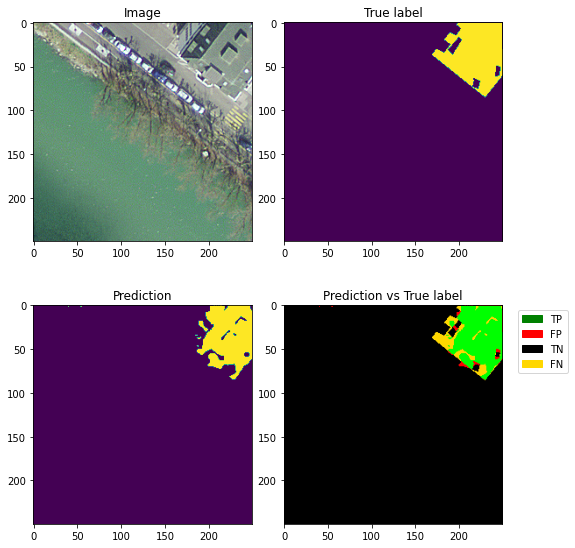

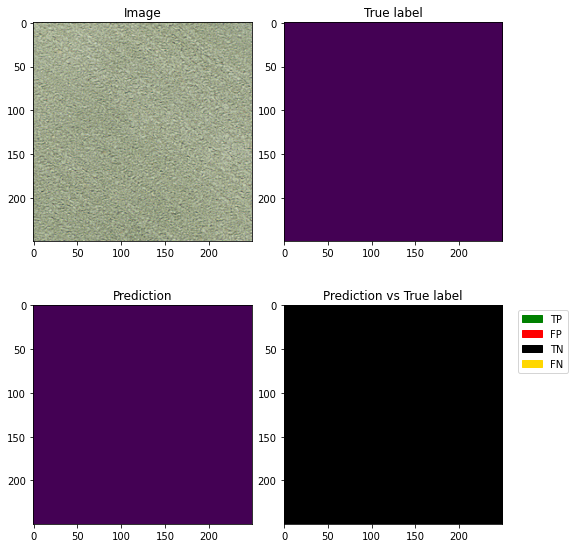

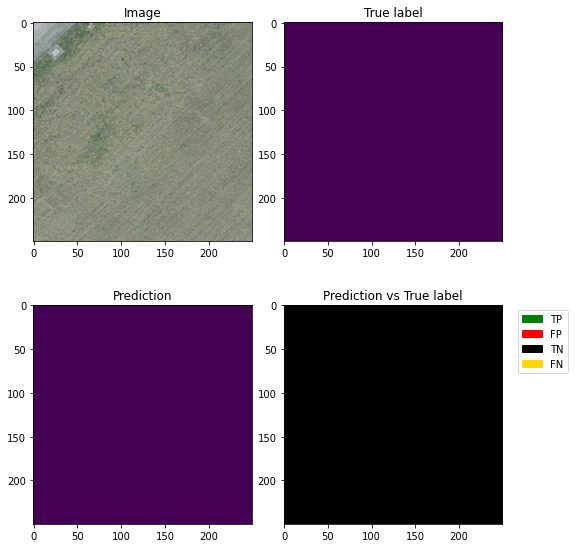

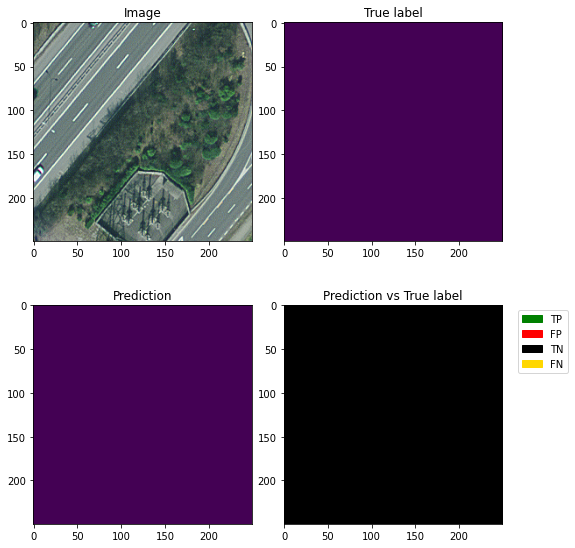

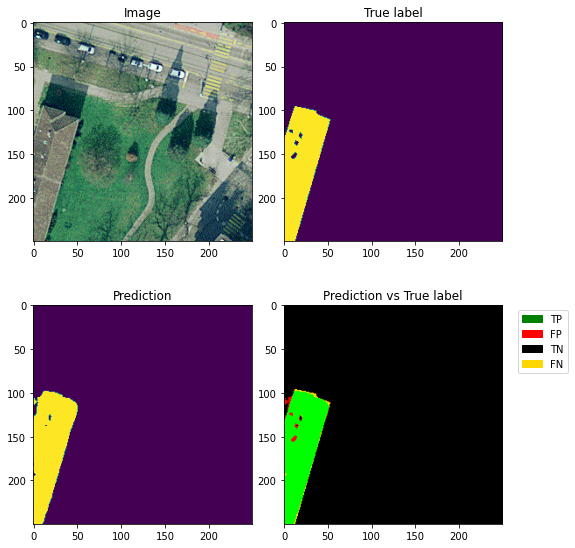

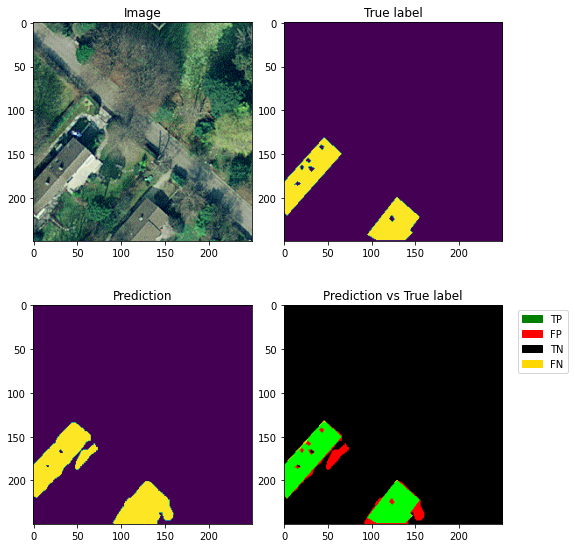

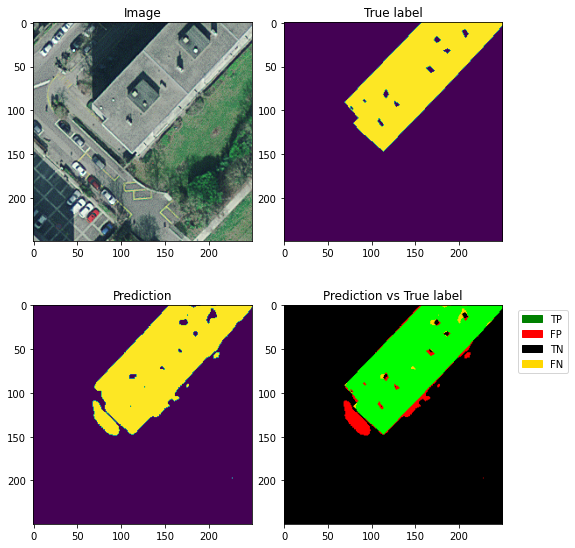

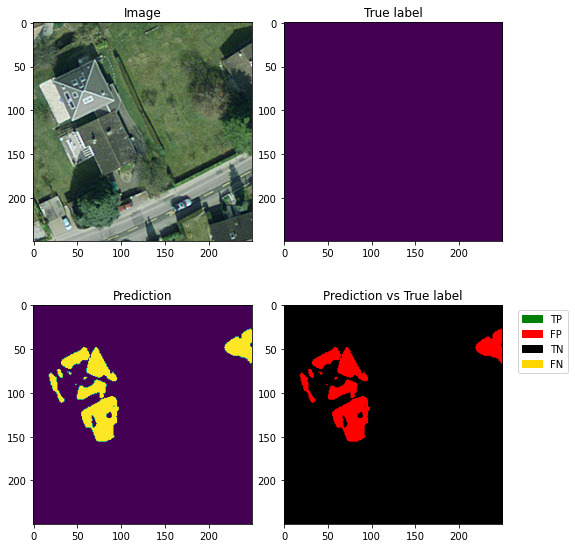

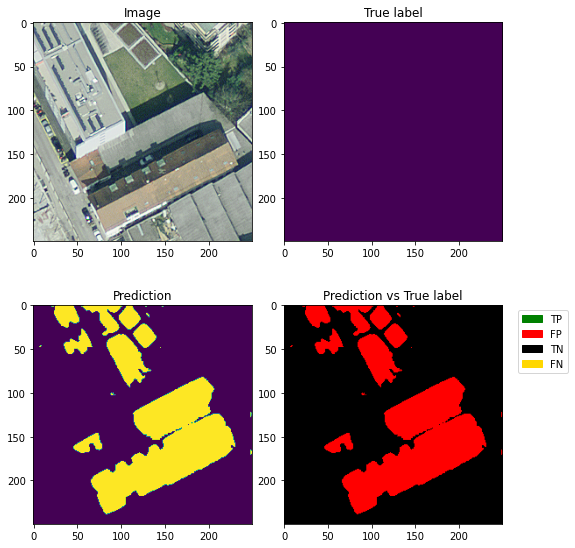

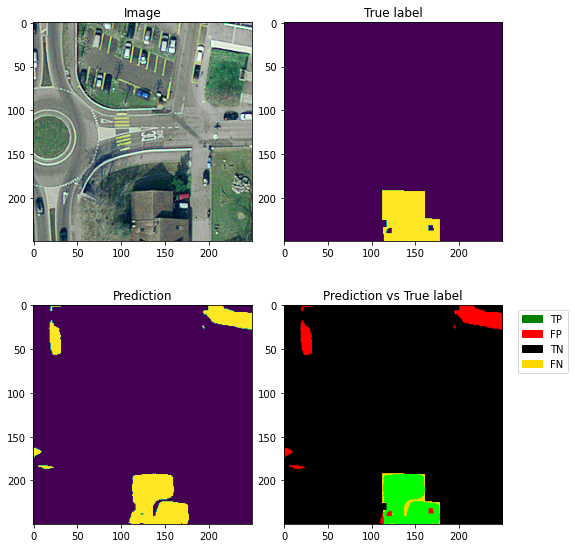

In [8]:
# Visualise predictions of the model on individual images
try:
    best_threshold
except NameError:
    # Arbitrary
    best_threshold = 0.5
    
vizualization_generator = show_full_comparisonTestGenerator(
    model, threshold_prediction=best_threshold
)
images_to_show = 10
count = 0
for _ in vizualization_generator:
    count += 1
    print(f"Loading image {count}")
    if count >= images_to_show:
        print("Displaying")
        break